<a href="https://colab.research.google.com/github/Priyabratagni/DBMI_Demographic_Bias_in_Medical_Imaging/blob/main/EfficientNetModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Installing Requirements

## Importing Required Libraries

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
import timm
import torch.optim as optim

## Load the csv file and Image data

In [2]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DermaMNISTDataset.csv')
npz = np.load('/content/drive/MyDrive/Colab Notebooks/DermaMNIST_Corrected_224.npz')

In [3]:
df

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,split
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern,train
1,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern,train
2,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern,train
3,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern,train
4,HAM_0001466,ISIC_0027850,bkl,histo,75.0,male,ear,vidir_modern,train
...,...,...,...,...,...,...,...,...,...
10010,HAM_0007199,ISIC_0030344,akiec,histo,55.0,female,face,rosendahl,test
10011,HAM_0003934,ISIC_0027767,akiec,histo,85.0,male,back,rosendahl,test
10012,HAM_0006587,ISIC_0025780,akiec,histo,70.0,male,face,rosendahl,test
10013,HAM_0006902,ISIC_0031506,akiec,histo,70.0,male,hand,rosendahl,test


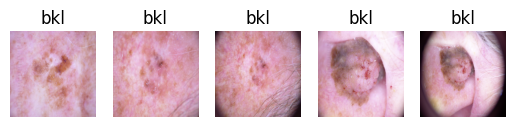

In [4]:
import matplotlib.pyplot as plt

colums_dx = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DermaMNISTDataset.csv')['dx']
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(npz['train_images'][i])
    plt.title(colums_dx[i])
    plt.axis('off')
plt.show()

Convert text classes to Numerical Format

In [5]:
label_encoder = LabelEncoder()
df['dx_enc'] = label_encoder.fit_transform(df['dx'])

In [6]:
class DermaDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images.astype(np.float32) / 255.0
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        img = np.transpose(img, (2, 0, 1))
        label = self.labels[idx]
        return torch.tensor(img, dtype=torch.float32), torch.tensor(label, dtype=torch.long)

In [7]:
train_idx = df[df['split'] == 'train'].index
val_idx = df[df['split'] == 'val'].index
test_idx = df[df['split'] == 'test'].index

In [8]:
train_labels = df.loc[train_idx, 'dx_enc'].to_numpy()
val_labels = df.loc[val_idx, 'dx_enc'].to_numpy()
test_labels = df.loc[test_idx, 'dx_enc'].to_numpy()

In [9]:
trainset = DermaDataset(npz['train_images'], train_labels)
valset = DermaDataset(npz['val_images'], val_labels)
testset = DermaDataset(npz['test_images'], test_labels)

In [10]:
train_loader = DataLoader(trainset, batch_size=32, shuffle=True)
val_loader = DataLoader(valset, batch_size=32)
test_loader = DataLoader(testset, batch_size=32)

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = timm.create_model('efficientnet_b1', pretrained=True)
model.classifier = nn.Linear(model.classifier.in_features, 7)
model = model.to(device)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/31.5M [00:00<?, ?B/s]

In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)


In [33]:
num_epochs = 10

# Initialize lists to track metrics
train_losses = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")

    # --- Training step ---
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    train_loss = running_loss / len(train_loader.dataset)

    # --- Validation step ---
    model.eval()
    val_loss = 0.0
    correct = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            preds = outputs.argmax(1)
            correct += (preds == labels).sum().item()

    val_loss /= len(val_loader.dataset)
    val_acc = correct / len(val_loader.dataset)

    # Append metrics after each epoch
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

print(f"Training completed! Total epochs: {len(train_losses)}")

Epoch 1/10
Train Loss: 0.0401 | Val Loss: 0.5050 | Val Acc: 0.8988
Epoch 2/10
Train Loss: 0.0348 | Val Loss: 0.5063 | Val Acc: 0.8988
Epoch 3/10
Train Loss: 0.0348 | Val Loss: 0.5363 | Val Acc: 0.8953
Epoch 4/10
Train Loss: 0.0383 | Val Loss: 0.5358 | Val Acc: 0.8778
Epoch 5/10
Train Loss: 0.0244 | Val Loss: 0.4846 | Val Acc: 0.9040
Epoch 6/10
Train Loss: 0.0122 | Val Loss: 0.5594 | Val Acc: 0.9058
Epoch 7/10
Train Loss: 0.0245 | Val Loss: 0.5567 | Val Acc: 0.8691
Epoch 8/10
Train Loss: 0.0385 | Val Loss: 0.5016 | Val Acc: 0.8970
Epoch 9/10
Train Loss: 0.0242 | Val Loss: 0.5355 | Val Acc: 0.8901
Epoch 10/10
Train Loss: 0.0248 | Val Loss: 0.5365 | Val Acc: 0.8848
Training completed! Total epochs: 10


In [35]:
# ---- Test Evaluation ---- #
model.eval()
correct = 0
all_preds, all_labels = [], []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = outputs.argmax(1)
        correct += (preds == labels).sum().item()
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
test_acc = correct / len(test_loader.dataset)
print(f"Test Accuracy: {test_acc:.4f}")


Test Accuracy: 0.8859


In [36]:
print("Epochs:", num_epochs)
print("Train Losses:", len(train_losses))
print("Val Losses:", len(val_losses))
print("Val Accuracies:", len(val_accuracies))

Epochs: 10
Train Losses: 10
Val Losses: 10
Val Accuracies: 10


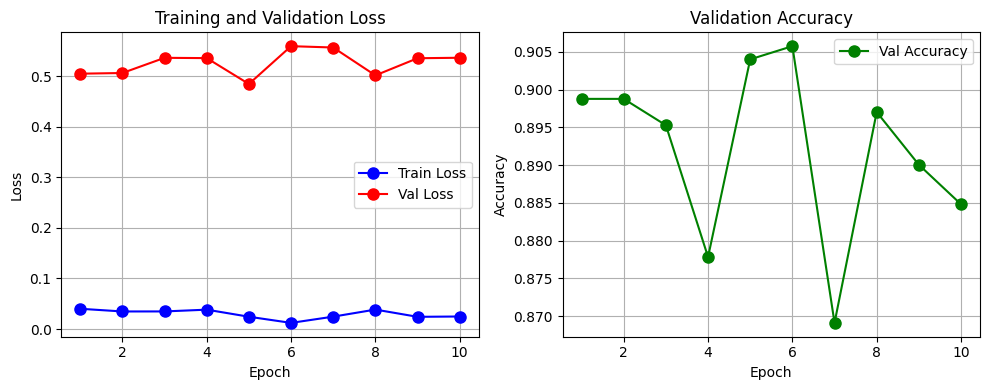

Completed epochs: 10
Train Loss: [0.0401209429524441, 0.03477067623289707, 0.03484811203682379, 0.03834639041799637, 0.02436403370550502, 0.012194907040432593, 0.024541579406185284, 0.038513061900669054, 0.024189320461197043, 0.024820661352980233]
Val Loss: [0.5049615463686467, 0.5062965577237477, 0.5363234784437854, 0.535751784847721, 0.4846012441791475, 0.5593704993035693, 0.5567234952821938, 0.5016000195798288, 0.535513484912289, 0.5364542095296176]
Val Accuracy: [0.8987783595113438, 0.8987783595113438, 0.8952879581151832, 0.8778359511343804, 0.9040139616055847, 0.9057591623036649, 0.8691099476439791, 0.8970331588132635, 0.8900523560209425, 0.8848167539267016]


In [37]:
import matplotlib.pyplot as plt

completed_epochs = len(train_losses)
epochs_completed = range(1, completed_epochs + 1)

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)

plt.plot(epochs_completed, train_losses, 'bo-', label='Train Loss', markersize=8)
plt.plot(epochs_completed, val_losses, 'ro-', label='Val Loss', markersize=8)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(epochs_completed, val_accuracies, 'go-', label='Val Accuracy', markersize=8)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

print(f"Completed epochs: {completed_epochs}")
print(f"Train Loss: {train_losses}")
print(f"Val Loss: {val_losses}")
print(f"Val Accuracy: {val_accuracies}")

In [38]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

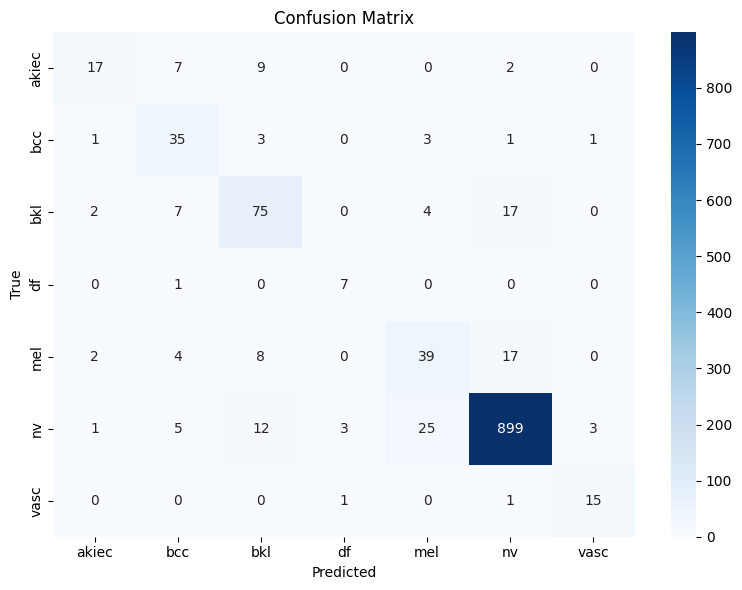

In [39]:
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

In [40]:
report = classification_report(
    all_labels,
    all_preds,
    target_names=label_encoder.classes_,
    digits=3
)
print(report)

              precision    recall  f1-score   support

       akiec      0.739     0.486     0.586        35
         bcc      0.593     0.795     0.680        44
         bkl      0.701     0.714     0.708       105
          df      0.636     0.875     0.737         8
         mel      0.549     0.557     0.553        70
          nv      0.959     0.948     0.954       948
        vasc      0.789     0.882     0.833        17

    accuracy                          0.886      1227
   macro avg      0.710     0.751     0.722      1227
weighted avg      0.890     0.886     0.887      1227



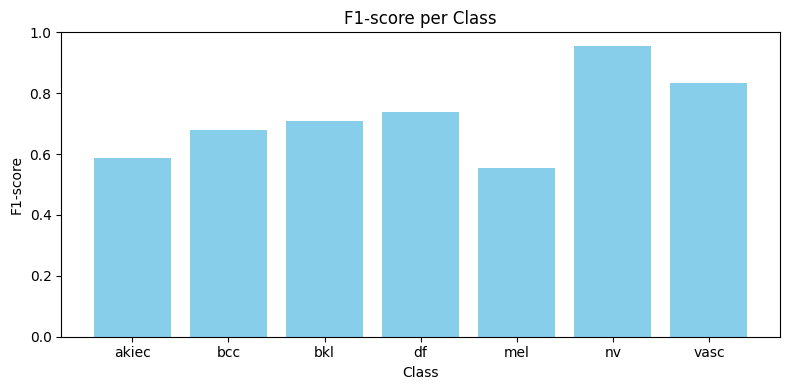

In [41]:
import numpy as np

report_dict = classification_report(
    all_labels, all_preds, target_names=label_encoder.classes_, output_dict=True
)
f1_scores = [report_dict[c]['f1-score'] for c in label_encoder.classes_]

plt.figure(figsize=(8,4))
plt.bar(label_encoder.classes_, f1_scores, color='skyblue')
plt.xlabel('Class')
plt.ylabel('F1-score')
plt.title('F1-score per Class')
plt.ylim(0, 1)
plt.tight_layout()
plt.show()